In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function

from primel.samplers import (
    ImportanceSampler,
    RandomSampler,
    StratifiedSampler,
    LHSampler,
)
from primel.distributions import (
    Empirical,
    GaussianKDE,
    MultivariateUniform,
    MixtureModel,
    gaussian_kde,
)
from primel.early_stopping import EarlyStopping
from primel.adapters.gplearn import GPLearnAdapter, ImplicitSymbolicRegressor
from primel.fitness import induced_kl_divergence

%load_ext autoreload
%autoreload 2

In [2]:
random_state = 42
n_train = 41

def generate_circle_data(n_points, noise):
    """Generate noisy circle data."""
    theta = np.linspace(0, 2 * np.pi, n_points)
    X = np.column_stack([np.cos(theta) , np.sin(theta) ])
    X += np.random.normal(0, noise, X.shape)
    return X

train_data = generate_circle_data(n_train, 0.00)

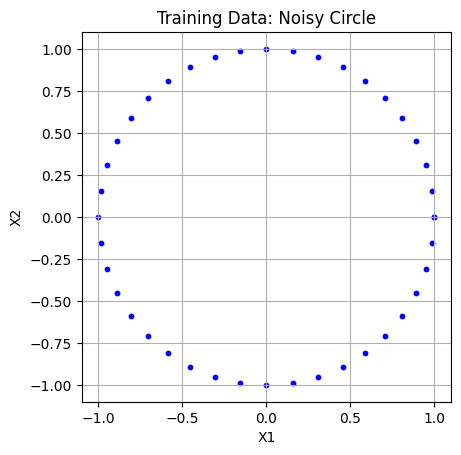

In [3]:
fig, ax = plt.subplots()
ax.scatter(train_data[:, 0], train_data[:, 1], s=10, color="blue")
ax.set_title("Training Data: Noisy Circle")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_aspect('equal')
ax.grid(True)

plt.show()

In [4]:
# bandwidths = np.logspace(4, -8, 13)
# for bandwidth in bandwidths:
#     empirical_dist = Empirical(data=train_data)
#     gaussian_kde_dist = GaussianKDE(X=train_data, bandwidth=bandwidth)
#     uniform_dist = MultivariateUniform(X=train_data, margins=0.1, non_negative=False)

#     sampler_entries = [
#         ("train", RandomSampler(empirical_dist), n_train, 1),
#         ("kde", RandomSampler(gaussian_kde_dist), n_train // 2, 1),
#         ("uniform", LHSampler(uniform_dist), n_train * 2, 2),
#     ]

#     sampler = ImportanceSampler(sampler_entries=sampler_entries, random_state=random_state)
#     samples = sampler.samples

#     def f(x):
#         return x[:, 0]**2 + x[:, 1]**2 - 1

#     trivial_y = np.zeros(sampler.samples.shape[0])
#     true_y = f(sampler.samples)

#     trivial_fitness = induced_kl_divergence(
#         trivial_y,
#         sampler,
#         reference_dist=gaussian_kde_dist,
#         mean_center_on="train",
#     )
#     true_fitness = induced_kl_divergence(
#         true_y,
#         sampler,
#         reference_dist=gaussian_kde_dist,
#         mean_center_on="train",
#     )

#     # print(trivial_fitness, true_fitness, trivial_fitness < true_fitness)
#     print(f"{bandwidth} \t {trivial_fitness} \t {true_fitness} \t {trivial_fitness < true_fitness}")

In [5]:
empirical_dist = Empirical(data=train_data)
# bandwidth
gaussian_kde_dist = GaussianKDE(X=train_data, bandwidth=1e-3)
uniform_dist = MultivariateUniform(X=train_data, margins=0.1, non_negative=False)

# Override gplearns save equations
# 30 trials
# sweep parameter from here
sampler_entries = [
    ("train", RandomSampler(empirical_dist), n_train),
    ("kde", RandomSampler(gaussian_kde_dist), 50),
    ("uniform", LHSampler(uniform_dist), 100),
]

sampler = ImportanceSampler(sampler_entries=sampler_entries, random_state=random_state)


samples = sampler.samples

<Figure size 1000x800 with 0 Axes>

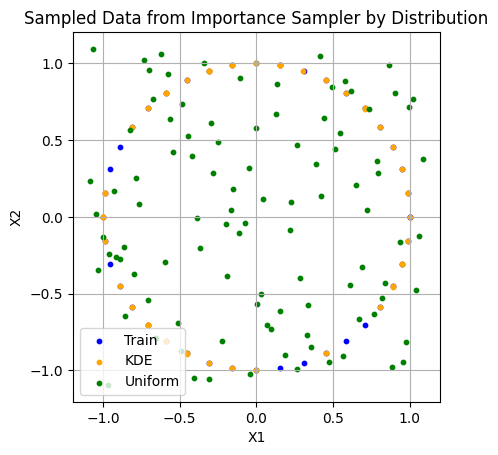

In [6]:
from_train = sampler.get_samples("train")
from_kde = sampler.get_samples("kde")
from_uniform = sampler.get_samples("uniform")

plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
ax.scatter(from_train[:, 0], from_train[:, 1], s=10, color="blue", label="Train")
ax.scatter(from_kde[:, 0], from_kde[:, 1], s=10, color="orange", label="KDE")
ax.scatter(from_uniform[:, 0], from_uniform[:, 1], s=10, color="green", label="Uniform")
ax.set_title("Sampled Data from Importance Sampler by Distribution")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

plt.show()

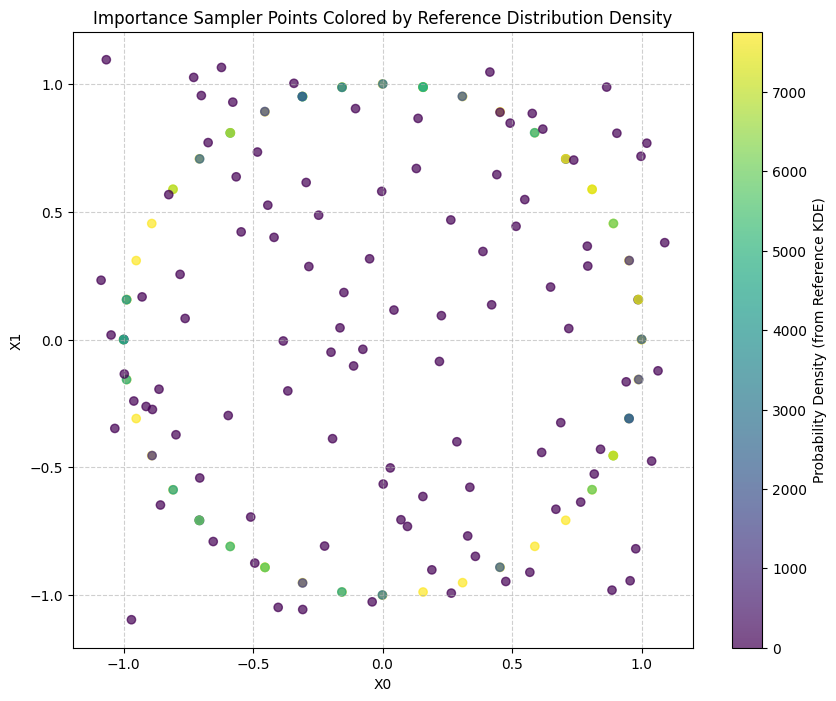

In [7]:
pdf_values = gaussian_kde_dist.pdf(sampler.samples)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    sampler.samples[:, 0],
    sampler.samples[:, 1],
    c=pdf_values,
    cmap='viridis',
    alpha=0.7
)

cbar = plt.colorbar(scatter)
cbar.set_label("Probability Density (from Reference KDE)")

plt.title("Importance Sampler Points Colored by Reference Distribution Density")
plt.xlabel("X0")
plt.ylabel("X1")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [8]:
# trivial_y = np.zeros(sampler.samples.shape[0])

In [9]:
# def f(x):
#     return x[:, 0]**2 + x[:, 1]**2 - 1

# true_y = f(sampler.samples)

# trivial_fitness = induced_kl_divergence(
#     trivial_y,
#     sampler,
#     reference_dist=gaussian_kde_dist,
#     mean_center_on="train",
# )
# true_fitness = induced_kl_divergence(
#     true_y,
#     sampler,
#     reference_dist=gaussian_kde_dist,
#     mean_center_on="train",
# )

# trivial_fitness, true_fitness

In [10]:
def _protected_division(x1, x2):
    """Closure of division (x1/x2) for zero denominator."""
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(np.abs(x2) > 1e-10, np.divide(x1, x2), 1.)

def _protected_log(x1):
    """Closure of log for zero and negative arguments."""
    with np.errstate(divide="ignore", invalid="ignore"):
        return np.where(np.abs(x1) > 1e-10, np.log(np.abs(x1)), 0.0)


div2 = make_function(function=_protected_division, name='div', arity=2)
log1 = make_function(function=_protected_log, name="log", arity=1)

In [11]:
early_stopping = EarlyStopping(
    sampler=sampler,
    train_X="train",
    total_variance_threshold=1e-4,
    training_variance_threshold=1e-6,
)
adapter = GPLearnAdapter(
    sampler=sampler,
    reference_distribution=gaussian_kde_dist,
    early_stopping=early_stopping,
    mean_center_on="train",
    lambda_=1.0,
    exponent=1.0,
)

est_gp = ImplicitSymbolicRegressor(
    function_set=[
        "add",
        "sub",
        "mul",
        div2,
        "sin",
        "cos",
        "tan",
        "sqrt",
        log1,
    ],
    adapter=adapter,
    population_size=500,
    generations=100,
    max_samples=0.9,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    verbose=1,
    # parsimony_coefficient=1e-1,
    parsimony_coefficient="auto",
    random_state=random_state,
)

est_gp.fit(sampler.samples, np.zeros(sampler.samples.shape[0]))
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.10          1.95039       11         0.416253         0.416253      3.67m
   1     3.24         0.546154        5         0.439353         0.439353      3.49m
   2     2.37         0.599087        5         0.439353         0.439353      3.15m
   3     1.42         0.533525        2         0.504095         0.504095      2.96m
   4     1.21         0.513586        2         0.504095         0.504095      5.60m
   5     1.50         0.546295        7         0.501443         0.501443      5.20m
   6     1.35         0.520948       11         0.494768         0.494768      3.07m
   7     1.37         0.605594        6         0.485034         0.485034      7.37m
   8     1.28         0.555776       11         0.463312         0.463312  

In [12]:
from gplearn.functions import _Function

rng = np.random.RandomState(random_state)
# program = est_gp._program.build_program(rng)
program = est_gp._program.program
# print(program)

for p in program:
    # print(type(p))
    if isinstance(p, _Function):
        print(p.name)
    else:
        print(p)

add
mul
0
0
mul
1
1


In [13]:
pred_y = est_gp.predict(sampler.samples)

In [14]:
induced_kl_divergence(
    pred_y,
    sampler,
    reference_dist=gaussian_kde_dist,
    mean_center_on="train",
)

0.3928636312404736

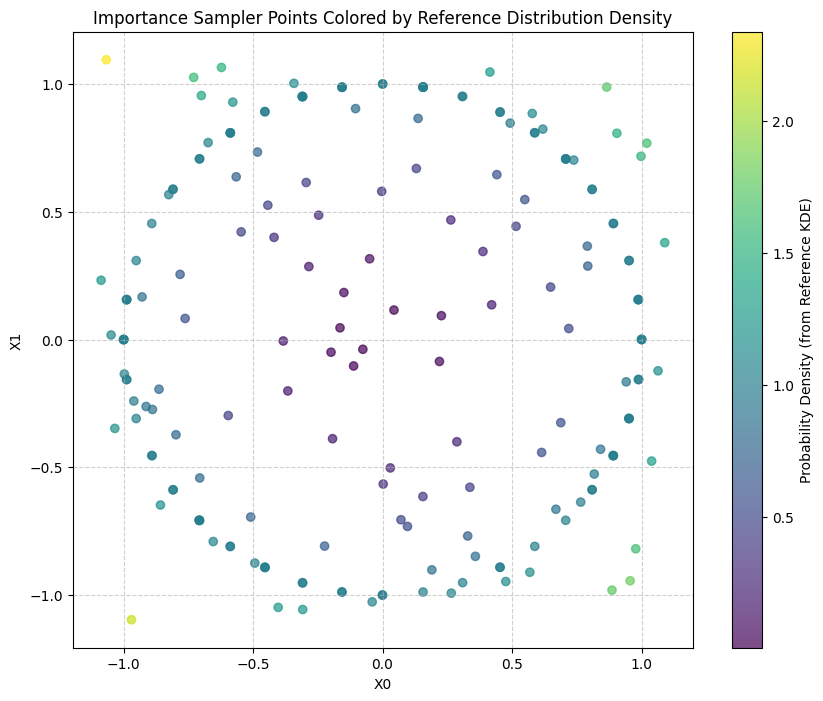

In [15]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    sampler.samples[:, 0],
    sampler.samples[:, 1],
    c=pred_y,
    cmap='viridis',
    alpha=0.7
)

cbar = plt.colorbar(scatter)
cbar.set_label("Probability Density (from Reference KDE)")

plt.title("Importance Sampler Points Colored by Reference Distribution Density")
plt.xlabel("X0")
plt.ylabel("X1")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [16]:
def f(x):
    return x[:, 0]**2 + x[:, 1]**2
    
true_y = f(sampler.samples)
induced_kl_divergence(
    true_y,
    sampler,
    reference_dist=gaussian_kde_dist,
    mean_center_on="train",
)

0.3928636312404736

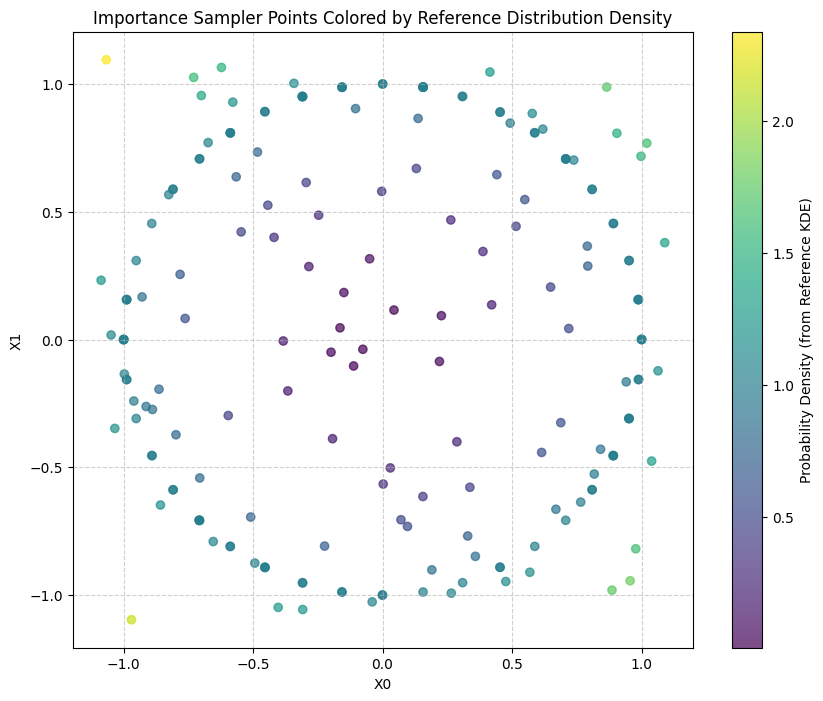

In [17]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    sampler.samples[:, 0],
    sampler.samples[:, 1],
    c=true_y,
    cmap='viridis',
    alpha=0.7
)

cbar = plt.colorbar(scatter)
cbar.set_label("Probability Density (from Reference KDE)")

plt.title("Importance Sampler Points Colored by Reference Distribution Density")
plt.xlabel("X0")
plt.ylabel("X1")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()